In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from pycox.models import LogisticHazard
from sklearn.model_selection import train_test_split
from pycox.evaluation import EvalSurv
import numpy as np
import wandb
from pycox.models.loss import NLLLogistiHazardLoss
from rna.encoder import RNAEncoder
from typing import List, Union, Dict, Any, Tuple
from torchvision import transforms
import json
from sklearn.preprocessing import FunctionTransformer

In [2]:
#!pip install einops

In [3]:
#!pip install wandb -qU

In [4]:
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: almachan2358 (gnn-neuro). Use `wandb login --relogin` to force relogin


True

In [5]:
run = wandb.init(project="cancer_mtcp",
                 config={"learning_rate": 1e-3 ,
                         "architecture": "base_CNN",
                         "num_epochs": 100})

In [6]:
#!pip install pycox

In [7]:
dataset_path ='../data/dataset.csv'

In [8]:
root_path ='../../../'

In [9]:
dataset=pd.read_csv(dataset_path)

In [165]:
dataset

,submitter_id,tumor_stage,age_at_diagnosis,prior_treatment,prior_malignancy,synchronous_malignancy,days_to_last_follow_up,gender,race,vital_status,...,IDH,MGMT,X1p19q,19.20.gain,7g10l,TERT,ATRX,DNAm,RNA,splits
0,TCGA-CS-4938,NaN,11509.0,No,no,No,3574.0,female,white,Alive,...,Mutant,Unmethylated,non-codel,No chr 19/20 gain,No combined CNA,Not expressed,Mutant,NaN,/DRIM/data/TCGA/GBMLGG/RNA/a282f56a-0884-40d2-...,0.0
1,TCGA-CS-4941,NaN,24578.0,No,no,No,NaN,male,white,Dead,...,WT,Methylated,non-codel,No chr 19/20 gain,Gain chr 7 & loss chr 10,Expressed,WT,NaN,/DRIM/data/TCGA/GBMLGG/RNA/20443648-a8c8-41ef-...,1.0
2,TCGA-CS-4942,NaN,16297.0,No,no,No,NaN,female,black or african american,Dead,...,Mutant,Unmethylated,non-codel,No chr 19/20 gain,No combined CNA,Not expressed,Mutant,NaN,/DRIM/data/TCGA/GBMLGG/RNA/81c11217-7d87-49a6-...,4.0
3,TCGA-CS-4943,NaN,13565.0,No,no,No,NaN,male,white,Dead,...,Mutant,Methylated,non-codel,No chr 19/20 gain,No combined CNA,Not expressed,Mutant,NaN,/DRIM/data/TCGA/GBMLGG/RNA/bb459bb7-ff32-431d-...,0.0
4,TCGA-CS-4944,NaN,18494.0,No,no,No,1828.0,male,white,Alive,...,Mutant,Methylated,non-codel,No chr 19/20 gain,No combined CNA,Expressed,WT,NaN,/DRIM/data/TCGA/GBMLGG/RNA/ddda9728-45af-4d0b-...,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1085,TCGA-41-2572,NaN,24505.0,No,NaN,NaN,NaN,male,white,Dead,...,WT,Unmethylated,non-codel,Gain chr 19/20,Gain chr 7 & loss chr 10,Expressed,WT,NaN,/DRIM/data/TCGA/GBMLGG/RNA/f9fd3da8-5a2d-4f4d-...,NaN
1089,TCGA-41-3915,NaN,17880.0,No,NaN,NaN,NaN,male,white,Dead,...,WT,Methylated,non-codel,No chr 19/20 gain,Gain chr 7 & loss chr 10,Expressed,WT,NaN,/DRIM/data/TCGA/GBMLGG/RNA/617be06c-8001-41ab-...,NaN
1090,TCGA-41-5651,NaN,21698.0,No,NaN,NaN,NaN,female,black or african american,Dead,...,WT,Methylated,non-codel,Gain chr 19/20,Gain chr 7 & loss chr 10,Expressed,WT,NaN,/DRIM/data/TCGA/GBMLGG/RNA/570657de-da5c-4b5a-...,NaN
1092,TCGA-76-4926,NaN,25085.0,No,NaN,NaN,NaN,male,white,Dead,...,WT,Unmethylated,non-codel,No chr 19/20 gain,Gain chr 7 & loss chr 10,Expressed,WT,NaN,/DRIM/data/TCGA/GBMLGG/RNA/b4abde15-98d3-4e78-...,NaN


In [166]:
dataset[['time', 'event', 'vital_status']]

,time,event,vital_status
0,9.791781,0,Alive
1,0.641096,1,Dead
2,3.657534,1,Dead
3,3.030137,1,Dead
4,5.008219,0,Alive
...,...,...,...
1085,1.112329,1,Dead
1089,0.986301,1,Dead
1090,1.260274,1,Dead
1092,0.378082,1,Dead


In [11]:
# class RNADataset(Dataset):
#     """RNA dataset."""

#     def __init__(self, data, root_dir, transform):
#         """
#         Arguments:
#             csv_file (string): Path to the csv file with annotations.
#             root_dir (string): Directory to RNA csv files
#             transform (callable, optional): Optional transform to be applied
#                 on a sample.
#         """
#         self.data = data
#         self.root_dir = root_dir
#         self.transform = transform

#     def __len__(self):
#         return self.data.shape[0]

#     def __getitem__(self, idx):
       
#         sample_path =self.data.iloc[idx]['RNA']
        
#         sample =pd.read_csv(self.root_dir+sample_path)["fpkm_uq_unstranded"].values.reshape(1, -1)
        
#         sample = torch.from_numpy(sample)
        
#         if self.transform:
#             sample = self.transform(sample)
#         return sample

In [12]:
# class RNASurvivalDataset(RNADataset):
#     """RNA dataset."""

#     def __init__(self, data,root_dir, times, events, transform=None):
#         super().__init__(data, root_dir, transform)
#         self.times =times
#         self.events =events


#     def __getitem__(self, idx):
        
#         sample =super().__getitem__(idx)
#         return sample.float(), self.times[idx],self.events[idx]

In [13]:
class BaseDataset(Dataset):
    
    def __init__(self, data, root_dir, transform = None , is_hazard_logits = False):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory to RNA csv files
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data = data
        self.root_dir = root_dir
        self.transform = transform
        self.is_hazard_logits = is_hazard_logits

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
         raise NotImplementedError("This is absctract class")

In [14]:
class RNADataset(BaseDataset):
    """RNA dataset."""

    def __init__(self, data, root_dir, transform = None, is_hazard_logits = False):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory to RNA csv files
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        super().__init__(data, root_dir, transform, is_hazard_logits)

    def __getitem__(self, idx):
       
        sample_path =self.data.iloc[idx]['RNA']
        
        sample =pd.read_csv(self.root_dir+sample_path)["fpkm_uq_unstranded"].values.reshape(1, -1)
        
        if self.transform:
            sample = self.transform(sample)
            
        sample = torch.from_numpy(sample)
        
        if self.is_hazard_logits:
            return sample.float(), self.data.iloc[idx]['new_time'], self.data.iloc[idx]['new_event']
        else: 
            return sample.float(), self.data.iloc[idx]['time'], self.data.iloc[idx]['event']

In [15]:
fold_ind =0

In [16]:
dataset =dataset.loc[dataset.RNA.notnull()]
dataset_test =dataset.loc[dataset.group =='test'].reset_index(drop=True)
dataset_train_val = dataset.loc[dataset.group =='train']
dataset_val = dataset_train_val[dataset_train_val.splits==fold_ind].reset_index(drop=True)
dataset_train = dataset_train_val[dataset_train_val.splits!=fold_ind].reset_index(drop=True)

In [17]:
dataset_val

,submitter_id,tumor_stage,age_at_diagnosis,prior_treatment,prior_malignancy,synchronous_malignancy,days_to_last_follow_up,gender,race,vital_status,...,IDH,MGMT,X1p19q,19.20.gain,7g10l,TERT,ATRX,DNAm,RNA,splits
0,TCGA-CS-4938,NaN,11509.0,No,no,No,3574.0,female,white,Alive,...,Mutant,Unmethylated,non-codel,No chr 19/20 gain,No combined CNA,Not expressed,Mutant,NaN,/DRIM/data/TCGA/GBMLGG/RNA/a282f56a-0884-40d2-...,0.0
1,TCGA-CS-4943,NaN,13565.0,No,no,No,NaN,male,white,Dead,...,Mutant,Methylated,non-codel,No chr 19/20 gain,No combined CNA,Not expressed,Mutant,NaN,/DRIM/data/TCGA/GBMLGG/RNA/bb459bb7-ff32-431d-...,0.0
2,TCGA-CS-5396,NaN,19399.0,No,no,No,1631.0,female,white,Alive,...,Mutant,Methylated,codel,No chr 19/20 gain,No combined CNA,Expressed,WT,NaN,/DRIM/data/TCGA/GBMLGG/RNA/7a2cd40f-7835-4323-...,0.0
3,TCGA-CS-6188,NaN,17729.0,No,no,No,NaN,male,white,Dead,...,WT,Unmethylated,non-codel,No chr 19/20 gain,Gain chr 7 & loss chr 10,Expressed,WT,NaN,/DRIM/data/TCGA/GBMLGG/RNA/7fc3fecc-8b19-415f-...,0.0
4,TCGA-CS-6665,NaN,18977.0,No,yes,NaN,1568.0,female,white,Alive,...,Mutant,Methylated,non-codel,No chr 19/20 gain,No combined CNA,Not expressed,WT,NaN,/DRIM/data/TCGA/GBMLGG/RNA/38657792-ba50-4dfe-...,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,TCGA-28-1747,NaN,16301.0,No,NaN,NaN,NaN,male,white,Dead,...,WT,Methylated,non-codel,No chr 19/20 gain,No combined CNA,Expressed,WT,NaN,/DRIM/data/TCGA/GBMLGG/RNA/20445437-9781-49d6-...,0.0
101,TCGA-28-2514,NaN,16737.0,No,NaN,NaN,160.0,male,asian,Alive,...,WT,Unmethylated,non-codel,No chr 19/20 gain,No combined CNA,Expressed,WT,NaN,/DRIM/data/TCGA/GBMLGG/RNA/7a7637d0-110f-4809-...,0.0
102,TCGA-28-5208,NaN,19053.0,No,NaN,NaN,NaN,male,white,Dead,...,WT,Methylated,non-codel,No chr 19/20 gain,No combined CNA,Expressed,WT,NaN,/DRIM/data/TCGA/GBMLGG/RNA/21b8a64f-800c-45bc-...,0.0
103,TCGA-28-5209,NaN,24362.0,No,NaN,NaN,442.0,female,white,Alive,...,WT,Methylated,non-codel,No chr 19/20 gain,Gain chr 7 & loss chr 10,Expressed,WT,NaN,/DRIM/data/TCGA/GBMLGG/RNA/9c73dcae-262a-4473-...,0.0


In [18]:
class Scale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, file_path):
        self.load_scaling(file_path)
        
    def load_scaling(self, file_path):    
        with open(file_path, 'r') as file:
            self.scaler_data = json.load(file)

    def __call__(self, sample):
        sample =(sample - np.array(self.scaler_data['mean_values'])) / np.array(self.scaler_data['var_values'])

        return sample

In [19]:
def log_transform(x):
    return np.log(x + 1)

In [20]:
transform = transforms.Compose([transforms.Lambda(log_transform), Scale('scaler_data.json')])

In [21]:
dataframes = {"train" : dataset_train, "val" : dataset_val, "test" : dataset_test}

In [43]:
datasets, dataloaders = {}, {}
events, times ={}, {}
n_intervals = 20
labtrans = LogisticHazard.label_transform(n_intervals)
labtrans.fit(dataframes['train']['time'], dataframes['train']['event'])


for split, dataframe in dataframes.items():
    dataframe['new_time'], dataframe['new_event'] =labtrans.transform(dataframe['time'], dataframe['event'])
    datasets[split] = RNADataset(dataframe, root_path, transform=transform,is_hazard_logits = True )
    if split =='train':
        dataloaders[split] =DataLoader(datasets[split],shuffle=True, batch_size=24)
    else:
        dataloaders[split] =DataLoader(datasets[split],shuffle=False, batch_size=1)

In [44]:
## Переведем наши (time, events) в новое количество интервалов
value, st, ind =next(iter(dataloaders['train']))

In [45]:
next(iter(dataloaders['val']))

[tensor([[[ 3.0241,  3.3031,  0.9420,  ..., -2.4838, -2.1773, -3.0219]]]),
 tensor([10]),
 tensor([0.])]

In [46]:
next(iter(dataloaders['test']))

[tensor([[[-0.4183, -0.0568, -3.2477,  ..., -2.5360, -1.7417, -1.9319]]]),
 tensor([0]),
 tensor([0.])]

In [47]:
def create_nan_dataframe(
    num_row: int, num_col: int, name_col: List[str]
) -> pd.DataFrame:
    df = pd.DataFrame(np.zeros((num_row, num_col)), columns=name_col)
    df[:] = np.nan
    return df

def interpolate_dataframe(dataframe: pd.DataFrame, n: int = 10) -> pd.DataFrame:
    dataframe.reset_index(inplace=True)
    dataframe_list = []
    for i, idx in enumerate(dataframe.index):
        df_temp = dataframe[dataframe.index == idx]
        dataframe_list.append(df_temp)
        if i != len(dataframe) - 1:
            dataframe_list.append(
                create_nan_dataframe(n, df_temp.shape[1], df_temp.columns)
            )

    dataframe = pd.concat(dataframe_list).interpolate("linear")
    dataframe = dataframe.set_index("index")
    return dataframe

In [48]:
def compute_survival_metrics(outputs, time, event, cuts):
        """
        Compute the survival metrics with the PyCox package.
        """
        hazard = torch.cat(outputs, dim=0)
        survival = (1 - hazard.sigmoid()).add(1e-7).log().cumsum(1).exp().cpu().numpy()
        survival =pd.DataFrame(survival.transpose())
        #survival = interpolate_dataframe(pd.DataFrame(survival.transpose(), cuts))
        evaluator = EvalSurv(
            survival, time.cpu().numpy(), event.cpu().numpy(), censor_surv="km"
        )
        c_index = evaluator.concordance_td()
        ibs = evaluator.integrated_brier_score(np.linspace(0, time.cpu().numpy().max()))
        inbll = evaluator.integrated_nbll(np.linspace(0, time.cpu().numpy().max()))
        cs_score = (c_index + (1 - ibs)) / 2
        return {"c_index": c_index, "ibs": ibs, "inbll": inbll, "cs_score": cs_score}

In [49]:
class RNABaseSurvival(RNAEncoder):
    
    def __init__(self, embedding_dim: int, dropout: float, n_outs: int):
        
        super().__init__(embedding_dim=embedding_dim, dropout=dropout)
        self.n_outs = n_outs
        self.lin = torch.nn.Linear(embedding_dim,self.n_outs)
        
    def forward(self, x):
        x = self.encoder(x).squeeze(-1)
        x = self.lin(x)
        return(x)

In [50]:
model =RNABaseSurvival(embedding_dim=128, dropout=0.2,n_outs =n_intervals)

In [51]:
model

RNABaseSurvival(
  (encoder): Sequential(
    (0): Conv1d(1, 8, kernel_size=(9,), stride=(3,))
    (1): GELU(approximate='none')
    (2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv1d(8, 32, kernel_size=(9,), stride=(3,))
    (5): GELU(approximate='none')
    (6): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.2, inplace=False)
    (8): Conv1d(32, 64, kernel_size=(9,), stride=(3,))
    (9): GELU(approximate='none')
    (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.2, inplace=False)
    (12): Conv1d(64, 128, kernel_size=(9,), stride=(3,))
    (13): GELU(approximate='none')
    (14): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): Dropout(p=0.2, inplace=False)
    (16): Conv1d(128, 256, kernel_size=(9,), stride=(3,))
    (17): GELU(approximate='

In [52]:
x,times,events =next(iter(dataloaders['train']))

In [53]:
#model=model.to(float)

In [54]:
out =model(x)

In [55]:
#compute_survival_metrics([out], torch.cat([times], dim=0), torch.cat([events], dim=0), labtrans.cuts)

In [56]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)

In [57]:
n_epochs=50

In [58]:
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs,eta_min=5e-6)

In [59]:
criterion = NLLLogistiHazardLoss()

In [60]:
device ='cuda:1'

In [61]:
model =model.to(device)

In [62]:
for epoch in range(n_epochs):
    total_task_loss =0
    model.train()
    for batch in dataloaders['train']:
        
        data, time, event = batch
        outputs =model(data.to(device))
        
        loss = criterion(outputs, time.to(device), event.to(device))
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
        
        total_task_loss+=loss
        
    scheduler.step()
    results = {"task_loss": total_task_loss / len(dataloaders['train'].dataset)}
    
    total_val_loss =0 
    preds,all_times, all_events = [], [], []
    model.eval()
    with torch.no_grad():    
        for batch in dataloaders['val']:
            
             data, time, event = batch
             outputs =model(data.to(device))
             loss = criterion(outputs, time.to(device), event.to(device))
             preds.append(outputs)
             all_times.append(time)
             all_events.append(event)
             total_val_loss +=loss
    results.update({"val_loss": total_val_loss / len(dataloaders['val'].dataset)})            
    val_metrics =compute_survival_metrics(preds, torch.cat(all_times, dim=0), torch.cat(all_events, dim=0), labtrans.cuts)
    results.update(val_metrics)
    wandb.log(results)

In [63]:
results

{'task_loss': tensor(0.0027, device='cuda:1', grad_fn=<DivBackward0>),
 'val_loss': tensor(0.9233, device='cuda:1'),
 'c_index': 0.7718733225979603,
 'ibs': 0.15768846515846685,
 'inbll': 0.5021036213514602,
 'cs_score': 0.8070924287197467}

In [65]:
preds

[tensor([[-4.6551, -3.8372, -3.1300, -7.6737, -1.3524,  0.0315, -2.4926, -2.2589,
          -4.7184,  0.7606,  0.7655,  2.4500, -0.4775, -2.9557, -1.6446, -1.9790,
          -1.7393, -1.9115, -1.4760, -1.9474]], device='cuda:1'),
 tensor([[-4.5220, -4.7575, -2.6068, -8.4821, -2.5614,  1.2866, -2.0818, -4.0757,
          -4.9685,  1.2192, -0.3948,  2.4986, -0.7446, -3.1873, -1.4005, -2.2126,
          -1.5325, -2.2409, -1.7582, -1.9154]], device='cuda:1'),
 tensor([[-3.9231, -3.4064, -1.6975, -5.1777, -1.5489, -0.4385, -2.3231, -1.9435,
          -3.2155,  0.4473,  0.5765,  2.1441, -0.2284, -2.5810, -0.8796, -1.3929,
          -0.9918, -1.4852, -0.9205, -1.5907]], device='cuda:1'),
 tensor([[-4.8099, -2.0543,  1.6525, -4.3360, -1.1274,  3.8087,  0.0929, -0.4609,
          -1.1906,  2.3849,  1.4790,  3.6143,  0.4139, -1.6300,  0.3261,  0.4881,
          -0.7650, -0.3188,  0.3377,  0.0141]], device='cuda:1'),
 tensor([[-5.0060, -4.7241, -2.8836, -7.7565, -1.2842,  1.2758, -1.8645, -2.3603

In [87]:
torch.cat(all_events)

tensor([0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0.,
        0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0.,
        1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1.])

In [88]:
torch.cat(all_times)

tensor([10,  4,  4,  3,  4, 11,  6,  1,  2,  1,  5,  2,  1,  8,  8,  4,  1,  1,
         1,  2,  7,  6,  2,  7,  3,  1,  1,  1,  0,  3,  2,  0,  0,  1,  5,  1,
         0,  4,  0,  2,  0,  0,  1,  2,  0,  0,  2,  0,  0,  0,  5,  4,  2,  2,
         2,  0,  1,  1,  0,  1,  0,  5,  0,  1,  3,  2,  6,  0,  1,  1,  5,  4,
         2,  2,  2,  1,  5,  1,  0,  2,  1,  3,  4,  2,  1,  1,  1,  0,  2,  2,
         1,  2,  4,  2,  2,  0,  0,  0,  1,  2,  1,  0,  2,  1,  2])

In [66]:
hazard = torch.cat(preds, dim=0)
survival = (1 - hazard.sigmoid()).add(1e-7).log().cumsum(1).exp().cpu().numpy()

In [77]:
list((1-hazard.sigmoid()).log().cumsum(1).exp()[0])

[tensor(0.9906, device='cuda:1'),
 tensor(0.9697, device='cuda:1'),
 tensor(0.9291, device='cuda:1'),
 tensor(0.9286, device='cuda:1'),
 tensor(0.7378, device='cuda:1'),
 tensor(0.3631, device='cuda:1'),
 tensor(0.3354, device='cuda:1'),
 tensor(0.3037, device='cuda:1'),
 tensor(0.3010, device='cuda:1'),
 tensor(0.0959, device='cuda:1'),
 tensor(0.0304, device='cuda:1'),
 tensor(0.0024, device='cuda:1'),
 tensor(0.0015, device='cuda:1'),
 tensor(0.0014, device='cuda:1'),
 tensor(0.0012, device='cuda:1'),
 tensor(0.0010, device='cuda:1'),
 tensor(0.0009, device='cuda:1'),
 tensor(0.0008, device='cuda:1'),
 tensor(0.0006, device='cuda:1'),
 tensor(0.0006, device='cuda:1')]

In [69]:
list(survival[0])

[0.9905767,
 0.96967584,
 0.9290581,
 0.9286264,
 0.7378189,
 0.36310634,
 0.3353726,
 0.30365166,
 0.30096436,
 0.09586066,
 0.030431017,
 0.0024173197,
 0.0014918824,
 0.0014180858,
 0.0011885858,
 0.0010442581,
 0.0008882435,
 0.00077382376,
 0.00062986463,
 0.0005512361]

In [82]:
list(survival[16])

[0.99000895,
 0.9753268,
 0.9654133,
 0.96521014,
 0.36818013,
 0.23485199,
 0.2150562,
 0.1955076,
 0.19457875,
 0.07037575,
 0.017163422,
 0.0012763557,
 0.00082748523,
 0.0007977467,
 0.000709689,
 0.0006533454,
 0.0005916509,
 0.00052501884,
 0.0004426283,
 0.00040166816]

In [92]:
list(survival[5])

[0.9909656,
 0.972064,
 0.9497327,
 0.94937426,
 0.4761446,
 0.30232465,
 0.27606425,
 0.24590456,
 0.24332002,
 0.08511392,
 0.020200983,
 0.0014052902,
 0.0008823904,
 0.0008318282,
 0.0007050962,
 0.0006269503,
 0.00054568576,
 0.0004665873,
 0.00037486068,
 0.00032627684]

In [93]:
torch.cat(all_times)[5]

tensor(11)

In [94]:
torch.cat(all_events)[5]

tensor(0.)

In [90]:
torch.cat(all_times)[23]

tensor(7)

In [91]:
torch.cat(all_events)[23]

tensor(1.)

In [89]:
list(survival[23])

[0.9909644,
 0.9797046,
 0.94696563,
 0.94592875,
 0.8564666,
 0.55802685,
 0.5085648,
 0.47794828,
 0.46823102,
 0.13969141,
 0.05637174,
 0.0034707126,
 0.0020922064,
 0.0018915386,
 0.001375318,
 0.0011793581,
 0.00088881503,
 0.0007629653,
 0.0005914915,
 0.00050906744]

In [38]:
torch.tensor([1,2,3,4]).sigmoid()

tensor([0.7311, 0.8808, 0.9526, 0.9820])

In [39]:
len(preds)

107

In [40]:
len(torch.cat(all_times, dim=0))

107

In [41]:
hazard = torch.cat(preds, dim=0)

In [42]:
survival = (1 - hazard.sigmoid()).add(1e-7).log().cumsum(1).exp().cpu().numpy()

In [43]:
survival.shape

(107, 20)

In [99]:
datasets["val"].data[["time", "event", "new_time", "new_event"]]

,time,event,new_time,new_event
0,9.791781,0,10,0.0
1,3.030137,1,4,1.0
2,4.468493,0,4,0.0
3,2.230137,1,3,1.0
4,4.295890,0,4,0.0
...,...,...,...,...
100,0.210959,1,1,1.0
101,0.438356,0,0,0.0
102,1.490411,1,2,1.0
103,1.210959,0,1,0.0


In [115]:
val_data =datasets["val"].data[["time", "event", "new_time", "new_event"]]
train_data =datasets["train"].data[["time", "event", "new_time", "new_event"]]
test_data =datasets["test"].data[["time", "event", "new_time", "new_event"]]

In [114]:
val_data.loc[val_data.event==1]['new_time'].describe()

count    30.000000
mean      2.533333
std       1.634400
min       1.000000
25%       1.000000
50%       2.000000
75%       3.750000
max       7.000000
Name: new_time, dtype: float64

In [116]:
train_data.loc[train_data.event==1]['new_time'].describe()

count    167.000000
mean       3.185629
std        2.942466
min        1.000000
25%        1.000000
50%        2.000000
75%        4.000000
max       16.000000
Name: new_time, dtype: float64

In [173]:
import seaborn as sns

<Axes: >

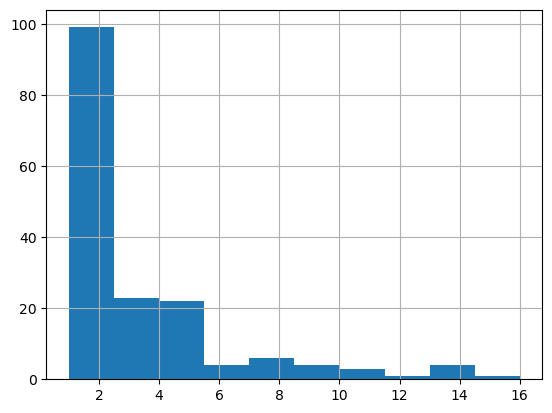

In [172]:
train_data.loc[train_data.event==1]['new_time'].hist()

<Axes: xlabel='new_time', ylabel='Density'>

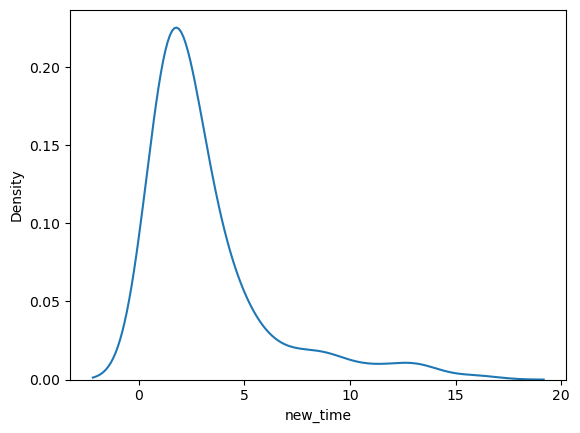

In [175]:
sns.kdeplot(train_data.loc[train_data.event==1]['new_time'])

In [259]:
train_data.loc[train_data.event==1]

,time,event,new_time,new_event
0,0.641096,1,1,1.0
1,3.657534,1,4,1.0
4,0.531507,1,1,1.0
5,1.473973,1,2,1.0
6,3.115068,1,4,1.0
...,...,...,...,...
422,0.400000,1,1,1.0
423,1.465753,1,2,1.0
424,0.257534,1,1,1.0
425,0.764384,1,1,1.0


In [278]:
train_data.loc[train_data.event==1]['new_time'].value_counts()

new_time
2     50
1     49
3     23
4     14
5      8
6      4
9      4
7      3
13     3
8      3
11     2
14     1
10     1
12     1
16     1
Name: count, dtype: int64

In [285]:
np.cumsum([49,50,23,14,8, 4,3,3,4, 1,2,1,3,1,0,1,0,0,0,0])/ np.sum(values)

array([0.29341317, 0.59281437, 0.73053892, 0.81437126, 0.86227545,
       0.88622754, 0.90419162, 0.92215569, 0.94610778, 0.95209581,
       0.96407186, 0.97005988, 0.98802395, 0.99401198, 0.99401198,
       1.        , 1.        , 1.        , 1.        , 1.        ])

In [286]:
1-np.cumsum([49,50,23,14,8, 4,3,3,4, 1,2,1,3,1,0,1,0,0,0,0])/ np.sum(values)

array([0.70658683, 0.40718563, 0.26946108, 0.18562874, 0.13772455,
       0.11377246, 0.09580838, 0.07784431, 0.05389222, 0.04790419,
       0.03592814, 0.02994012, 0.01197605, 0.00598802, 0.00598802,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [284]:
np.sum([49,50,23,14,8, 4,3,3,4, 1,2,1,3,1,0,1,0,0,0,0]/ np.sum(values))

1.0

In [279]:
values, base = np.histogram(train_data.loc[train_data.event==1]['new_time'].values, bins=20)

In [280]:
values

array([49, 50, 23,  0, 14,  8,  4,  0,  3,  3,  4,  0,  1,  2,  1,  0,  3,
        1,  0,  1])

In [262]:
sum(values)

167

In [263]:
base

array([ 1.  ,  1.75,  2.5 ,  3.25,  4.  ,  4.75,  5.5 ,  6.25,  7.  ,
        7.75,  8.5 ,  9.25, 10.  , 10.75, 11.5 , 12.25, 13.  , 13.75,
       14.5 , 15.25, 16.  ])

In [264]:
np.cumsum(values)

array([ 49,  99, 122, 122, 136, 144, 148, 148, 151, 154, 158, 158, 159,
       161, 162, 162, 165, 166, 166, 167])

In [265]:
sum(values)

167

In [266]:
cumulative = np.cumsum(values)/ sum(values)

In [267]:
cumulative

array([0.29341317, 0.59281437, 0.73053892, 0.73053892, 0.81437126,
       0.86227545, 0.88622754, 0.88622754, 0.90419162, 0.92215569,
       0.94610778, 0.94610778, 0.95209581, 0.96407186, 0.97005988,
       0.97005988, 0.98802395, 0.99401198, 0.99401198, 1.        ])

In [250]:
cumulative

array([0.9 , 1.8 , 1.8 , 2.1 , 2.15, 2.15, 2.25, 2.3 , 2.3 , 2.35, 2.4 ,
       2.4 , 2.4 , 2.4 , 2.4 , 2.4 , 2.4 , 2.4 , 2.4 , 2.5 ])

In [268]:
1-cumulative

array([0.70658683, 0.40718563, 0.26946108, 0.26946108, 0.18562874,
       0.13772455, 0.11377246, 0.11377246, 0.09580838, 0.07784431,
       0.05389222, 0.05389222, 0.04790419, 0.03592814, 0.02994012,
       0.02994012, 0.01197605, 0.00598802, 0.00598802, 0.        ])

In [236]:
import matplotlib.pyplot as plt

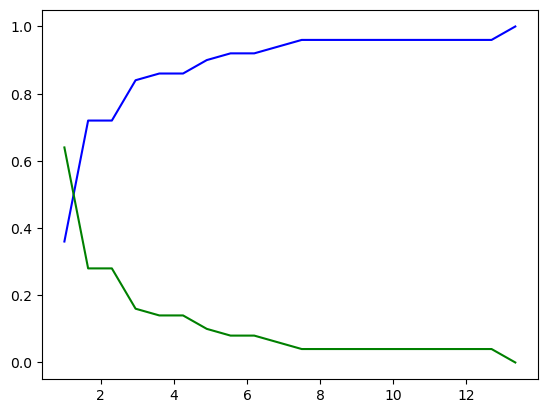

In [237]:
# plot the cumulative function
plt.plot(base[:-1], cumulative, c='blue')
#plot the survival function
plt.plot(base[:-1], 1-cumulative, c='green')

plt.show()

In [204]:
(1-cumulative).shape

(20,)

In [206]:
1-cumulative

array([0.70658683, 0.40718563, 0.26946108, 0.26946108, 0.18562874,
       0.13772455, 0.11377246, 0.11377246, 0.09580838, 0.07784431,
       0.05389222, 0.05389222, 0.04790419, 0.03592814, 0.02994012,
       0.02994012, 0.01197605, 0.00598802, 0.00598802, 0.        ])

In [231]:
test_data.loc[test_data.event==1]['new_time'].describe()

count    50.000000
mean      2.700000
std       2.808515
min       1.000000
25%       1.000000
50%       2.000000
75%       3.000000
max      14.000000
Name: new_time, dtype: float64

In [238]:
test_data.loc[test_data.event==0]['new_time'].describe()

count    82.000000
mean      1.878049
std       2.426145
min       0.000000
25%       0.000000
50%       1.000000
75%       3.000000
max      15.000000
Name: new_time, dtype: float64

<Axes: >

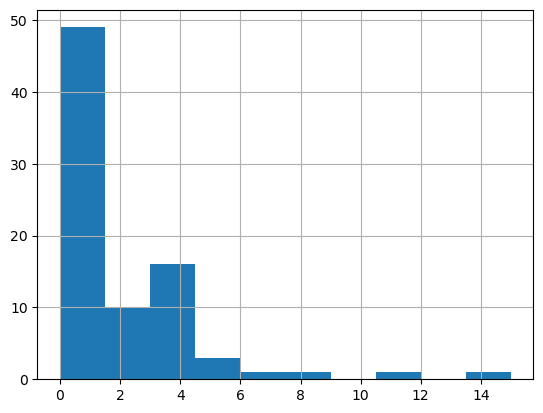

In [240]:
test_data.loc[test_data.event==0]['new_time'].hist()

In [232]:
values, base = np.histogram(test_data.loc[test_data.event==1]['new_time'].values, bins=20)

In [104]:
len(survival.transpose())

105

In [101]:
survival = pd.DataFrame(survival.transpose())

In [107]:
survival.transpose().describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
count,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,1.050000e+02,1.050000e+02,1.050000e+02,1.050000e+02,1.050000e+02,1.050000e+02,1.050000e+02,1.050000e+02,1.050000e+02,1.050000e+02,1.050000e+02,1.050000e+02,1.050000e+02,1.050000e+02
mean,0.991462,0.957212,0.698389,0.697147,0.490462,0.244314,2.234410e-01,2.067554e-01,2.036178e-01,6.337971e-02,2.300086e-02,1.808211e-03,1.138080e-03,1.065238e-03,8.567965e-04,7.606725e-04,6.102688e-04,5.392261e-04,4.410201e-04,3.896223e-04
std,0.003673,0.051753,0.355590,0.355991,0.323090,0.203757,1.917508e-01,1.815781e-01,1.793934e-01,6.389119e-02,2.572827e-02,2.594129e-03,1.720925e-03,1.623187e-03,1.322248e-03,1.196960e-03,9.069471e-04,8.218633e-04,6.865923e-04,6.183924e-04
min,0.979399,0.665998,0.003967,0.003671,0.001714,0.000007,8.025046e-07,1.494428e-07,4.314110e-08,3.483875e-09,4.969635e-10,1.436541e-11,3.464937e-12,2.641940e-12,6.867243e-13,1.144065e-13,7.139968e-14,2.065336e-14,6.051374e-15,1.578758e-15
25%,0.989717,0.959710,0.400309,0.395530,0.129751,0.018051,1.158940e-02,4.574477e-03,4.011781e-03,8.143215e-04,1.203250e-04,4.119470e-06,1.588940e-06,1.303846e-06,7.066299e-07,3.932181e-07,3.363270e-07,2.111975e-07,9.880314e-08,6.759839e-08
50%,0.991917,0.974677,0.928461,0.927005,0.606256,0.257386,2.314530e-01,2.256885e-01,2.244699e-01,5.943473e-02,2.020098e-02,1.199781e-03,7.289503e-04,6.651345e-04,4.803510e-04,4.119830e-04,3.575808e-04,3.124754e-04,2.594089e-04,2.218053e-04
75%,0.994190,0.982092,0.954284,0.953909,0.776455,0.399944,3.741735e-01,3.486742e-01,3.461234e-01,1.033384e-01,3.413009e-02,2.570517e-03,1.641510e-03,1.539999e-03,1.260259e-03,1.070295e-03,8.888150e-04,7.738238e-04,6.145115e-04,5.224964e-04
max,0.997052,0.992046,0.977673,0.977380,0.940907,0.677576,6.585131e-01,6.447690e-01,6.402896e-01,2.918833e-01,1.397139e-01,1.925605e-02,1.336058e-02,1.281026e-02,1.055128e-02,9.630576e-03,7.026196e-03,6.447695e-03,5.423206e-03,4.922906e-03


In [162]:
train_data

,time,event,new_time,new_event
0,0.641096,1,1,1.0
1,3.657534,1,4,1.0
2,5.008219,0,5,0.0
3,3.347945,0,3,0.0
4,0.531507,1,1,1.0
...,...,...,...,...
422,0.400000,1,1,1.0
423,1.465753,1,2,1.0
424,0.257534,1,1,1.0
425,0.764384,1,1,1.0


In [124]:
new_times =torch.cat(all_times, dim=0)
new_events =torch.cat(all_events, dim=0)

In [125]:
predictions=pd.DataFrame(np.zeros((new_times.shape[0], 20))).T

In [223]:
evel =EvalSurv(predictions,new_times.cpu().numpy(), new_events.cpu().numpy(), censor_surv="km")

In [224]:
c_index = evel.concordance_td()

In [225]:
c_index

0.5531400966183575

In [154]:
result = np.stack(([0.99, 0.95, 0.69, 0.69, 0.49, 0.24, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,0.0,  0.0, 0.0, 0.0,0.0, 0.0,0.0],) * new_times.shape[0], axis=1)

In [269]:
result =np.stack((1-cumulative, )* new_times.shape[0], axis=1)

In [270]:
result.shape

(20, 105)

In [271]:
predictions.loc[:,:] =result

In [272]:
predictions

,0,1,2,3,4,5,6,7,8,9,...,95,96,97,98,99,100,101,102,103,104
0,0.706587,0.706587,0.706587,0.706587,0.706587,0.706587,0.706587,0.706587,0.706587,0.706587,...,0.706587,0.706587,0.706587,0.706587,0.706587,0.706587,0.706587,0.706587,0.706587,0.706587
1,0.407186,0.407186,0.407186,0.407186,0.407186,0.407186,0.407186,0.407186,0.407186,0.407186,...,0.407186,0.407186,0.407186,0.407186,0.407186,0.407186,0.407186,0.407186,0.407186,0.407186
2,0.269461,0.269461,0.269461,0.269461,0.269461,0.269461,0.269461,0.269461,0.269461,0.269461,...,0.269461,0.269461,0.269461,0.269461,0.269461,0.269461,0.269461,0.269461,0.269461,0.269461
3,0.269461,0.269461,0.269461,0.269461,0.269461,0.269461,0.269461,0.269461,0.269461,0.269461,...,0.269461,0.269461,0.269461,0.269461,0.269461,0.269461,0.269461,0.269461,0.269461,0.269461
4,0.185629,0.185629,0.185629,0.185629,0.185629,0.185629,0.185629,0.185629,0.185629,0.185629,...,0.185629,0.185629,0.185629,0.185629,0.185629,0.185629,0.185629,0.185629,0.185629,0.185629
5,0.137725,0.137725,0.137725,0.137725,0.137725,0.137725,0.137725,0.137725,0.137725,0.137725,...,0.137725,0.137725,0.137725,0.137725,0.137725,0.137725,0.137725,0.137725,0.137725,0.137725
6,0.113772,0.113772,0.113772,0.113772,0.113772,0.113772,0.113772,0.113772,0.113772,0.113772,...,0.113772,0.113772,0.113772,0.113772,0.113772,0.113772,0.113772,0.113772,0.113772,0.113772
7,0.113772,0.113772,0.113772,0.113772,0.113772,0.113772,0.113772,0.113772,0.113772,0.113772,...,0.113772,0.113772,0.113772,0.113772,0.113772,0.113772,0.113772,0.113772,0.113772,0.113772
8,0.095808,0.095808,0.095808,0.095808,0.095808,0.095808,0.095808,0.095808,0.095808,0.095808,...,0.095808,0.095808,0.095808,0.095808,0.095808,0.095808,0.095808,0.095808,0.095808,0.095808
9,0.077844,0.077844,0.077844,0.077844,0.077844,0.077844,0.077844,0.077844,0.077844,0.077844,...,0.077844,0.077844,0.077844,0.077844,0.077844,0.077844,0.077844,0.077844,0.077844,0.077844


In [218]:
survival.T.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
count,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,1.050000e+02,1.050000e+02,1.050000e+02,1.050000e+02,1.050000e+02,1.050000e+02,1.050000e+02,1.050000e+02,1.050000e+02,1.050000e+02,1.050000e+02,1.050000e+02,1.050000e+02,1.050000e+02
mean,0.991462,0.957212,0.698389,0.697147,0.490462,0.244314,2.234410e-01,2.067554e-01,2.036178e-01,6.337971e-02,2.300086e-02,1.808211e-03,1.138080e-03,1.065238e-03,8.567965e-04,7.606725e-04,6.102688e-04,5.392261e-04,4.410201e-04,3.896223e-04
std,0.003673,0.051753,0.355590,0.355991,0.323090,0.203757,1.917508e-01,1.815781e-01,1.793934e-01,6.389119e-02,2.572827e-02,2.594129e-03,1.720925e-03,1.623187e-03,1.322248e-03,1.196960e-03,9.069471e-04,8.218633e-04,6.865923e-04,6.183924e-04
min,0.979399,0.665998,0.003967,0.003671,0.001714,0.000007,8.025046e-07,1.494428e-07,4.314110e-08,3.483875e-09,4.969635e-10,1.436541e-11,3.464937e-12,2.641940e-12,6.867243e-13,1.144065e-13,7.139968e-14,2.065336e-14,6.051374e-15,1.578758e-15
25%,0.989717,0.959710,0.400309,0.395530,0.129751,0.018051,1.158940e-02,4.574477e-03,4.011781e-03,8.143215e-04,1.203250e-04,4.119470e-06,1.588940e-06,1.303846e-06,7.066299e-07,3.932181e-07,3.363270e-07,2.111975e-07,9.880314e-08,6.759839e-08
50%,0.991917,0.974677,0.928461,0.927005,0.606256,0.257386,2.314530e-01,2.256885e-01,2.244699e-01,5.943473e-02,2.020098e-02,1.199781e-03,7.289503e-04,6.651345e-04,4.803510e-04,4.119830e-04,3.575808e-04,3.124754e-04,2.594089e-04,2.218053e-04
75%,0.994190,0.982092,0.954284,0.953909,0.776455,0.399944,3.741735e-01,3.486742e-01,3.461234e-01,1.033384e-01,3.413009e-02,2.570517e-03,1.641510e-03,1.539999e-03,1.260259e-03,1.070295e-03,8.888150e-04,7.738238e-04,6.145115e-04,5.224964e-04
max,0.997052,0.992046,0.977673,0.977380,0.940907,0.677576,6.585131e-01,6.447690e-01,6.402896e-01,2.918833e-01,1.397139e-01,1.925605e-02,1.336058e-02,1.281026e-02,1.055128e-02,9.630576e-03,7.026196e-03,6.447695e-03,5.423206e-03,4.922906e-03


In [276]:
new_times

tensor([10,  4,  4,  3,  4, 11,  6,  1,  2,  1,  5,  2,  1,  8,  8,  4,  1,  1,
         1,  2,  7,  6,  2,  7,  3,  1,  1,  1,  0,  3,  2,  0,  0,  1,  5,  1,
         0,  4,  0,  2,  0,  0,  1,  2,  0,  0,  2,  0,  0,  0,  5,  4,  2,  2,
         2,  0,  1,  1,  0,  1,  0,  5,  0,  1,  3,  2,  6,  0,  1,  1,  5,  4,
         2,  2,  2,  1,  5,  1,  0,  2,  1,  3,  4,  2,  1,  1,  1,  0,  2,  2,
         1,  2,  4,  2,  2,  0,  0,  0,  1,  2,  1,  0,  2,  1,  2])

In [277]:
new_events

tensor([0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0.,
        0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0.,
        1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1.])

In [273]:
evel =EvalSurv(predictions,new_times.cpu().numpy(), new_events.cpu().numpy())

In [274]:
c_index = evel.concordance_td()

In [275]:
c_index

0.5531400966183575

In [205]:
elems =next(iter(train_dataloader))

../../DRIM/data/TCGA/GBMLGG/RNA/7fe2d652-2dc5-4ac0-87d8-94fe389b8be0/4205fd72-6678-41d6-8059-2db00867a92a.rna_seq.augmented_star_gene_counts.csv


In [207]:
elems.shape

torch.Size([1, 1, 16304])

In [114]:
dataset_train.shape[0]

425

In [226]:
ibs =evel.integrated_brier_score(np.linspace(0, new_times.cpu().numpy().max()))

In [230]:
ibs

0.2916142232458687

In [227]:
evel.integrated_nbll(np.linspace(0, new_times.cpu().numpy().max()))

0.8391070749881006

In [228]:
cs_score = (c_index + (1 - ibs)) / 2

In [229]:
cs_score

0.6307629366862444